In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, OneHotEncoder,LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer


**Import Data**

In [ ]:
csv = ["application_train","bureau","bureau_balance","credit_card_balance",
      "HomeCredit_columns_description","installments_payments","POS_CASH_balance","previous_application",
      "sample_submission"]

app_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[0]+".csv")
bureau = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[1]+".csv")
bureau_balance = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[2]+".csv")
credit_balance = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[3]+".csv")
home_credit_des = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[4]+".csv")
install_payments = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[5]+".csv")
pos_cash_balance = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[6]+".csv")
prev_app = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[7]+".csv")
samp_sub = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/"+csv[8]+".csv")

df_name = {"app_train":app_train,"bureau":bureau,"bureau_balance":bureau_balance,
           "credit_balance":credit_balance,"home_credit_des":home_credit_des,
           "install_payments":install_payments,"pos_cash_balance":pos_cash_balance,
           "prev_app":prev_app,"samp_sub":samp_sub}

**Fonctions**

In [ ]:
def col_commun(data):
  for elt in data.columns:
    if elt in app_train.columns:
      print(elt,"\n")

def col_diff(data):
  for elt in data.columns:
    if elt not in app_train.columns:
      print(elt,"\n")

def correlation(dataset, threshold):
  col_corr = set() # Set of all the names of correlated columns
  corr_matrix = dataset.corr()

  for i in range(len(corr_matrix.columns)):
    for j in range(i):
      if corr_matrix.iloc[i,j] > threshold:
        colname = corr_matrix.columns[i]
        col_corr.add(colname)
  return col_corr

def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()

def plot_numerical(data, col, size=[8, 4], bins=50):
    '''use this for ploting the distribution of numerical features'''
    plt.figure(figsize=size)
    plt.title("Distribution of %s" % col)
    sns.distplot(data[col].dropna(), kde=True,bins=bins)
    plt.show()

def plot_categorical_bylabel(data, col, size=[12 ,6], xlabel_angle=0, title=''):
    '''use it to compare the distribution between label 1 and label 0'''
    plt.figure(figsize = size)
    l1 = data.loc[data.TARGET==1, col].value_counts()
    l0 = data.loc[data.TARGET==0, col].value_counts()
    plt.subplot(1,2,1)
    sns.barplot(x = l1.index, y=l1.values)
    plt.title('Target = 1: '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.subplot(1,2,2)
    sns.barplot(x = l0.index, y=l0.values)
    plt.title('Target = 0: '+title)
    plt.xticks(rotation=xlabel_angle)
    plt.show()

def plot_numerical_bylabel(data, col, size=[12, 6]):
    plt.figure(figsize=size)
    # Calculate the correlation coefficient between the new variable and the target
    corr = data['TARGET'].corr(data[col])
    
    # Calculate medians for repaid vs not repaid
    avg_repaid = data.loc[data['TARGET'] == 0, col].median()
    avg_not_repaid = data.loc[data['TARGET'] == 1, col].median()
    
    plt.figure(figsize = (12, 6))
    
    # Plot the distribution for target == 0 and target == 1
    sns.kdeplot(data.loc[data['TARGET'] == 0, col], label = 'TARGET == 0')
    sns.kdeplot(data.loc[data['TARGET'] == 1, col], label = 'TARGET == 1')
    
    # label the plot
    plt.xlabel(col); plt.ylabel('Density'); plt.title('%s Distribution' % col)
    plt.legend();
    # print out the correlation
    print('The correlation between %s and the TARGET is %0.4f' % (col, corr))


def feature_type_split(data):
    cat_list = []
    num_list = []
    for i in data.columns.tolist():
        if data[i].dtype == 'object':
            cat_list.append(i)
        else:
            num_list.append(i)
    return cat_list, num_list

**application_{train|test}.csv**

This is the main table for Train (with TARGET)
Static data for all applications. One row represents one loan in our data sample.

In [ ]:
app_train.shape

(307511, 122)

In [ ]:
app_train.columns.values

array(['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER',
       'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
       'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE',
       'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE',
       'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE',
       'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT',
       'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START',
       'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION',
       'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
       'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY',
       'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1',
       'EXT_SOURCE_2', 'EXT_SOURCE_3',

**Traitement des différents data sets pour ajouter les colonnes pertinentes dans le Data set principal (App_train)**

**Bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [ ]:
bureau.shape

(1716428, 17)

In [ ]:
col_commun(bureau)

SK_ID_CURR 

AMT_ANNUITY 



In [ ]:
bureau = bureau.drop(["AMT_ANNUITY"],axis=1)

In [ ]:
bureau.head(3)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16


In [ ]:
bureau_num = bureau.groupby(['SK_ID_CURR']).mean()
bureau_num = bureau_num[bureau_num.columns[1:]].reset_index()

In [ ]:
bureau_cat = bureau[["SK_ID_CURR","CREDIT_ACTIVE","CREDIT_TYPE"]].groupby("SK_ID_CURR").CREDIT_ACTIVE.max()

In [ ]:
bureau = bureau_num.merge(bureau_cat, on="SK_ID_CURR",how="left")

In [ ]:
bureau

,SK_ID_CURR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE
0,100001,-735.000000,0.0,82.428571,-825.500000,NaN,0.000000,2.076236e+05,85240.928571,0.00000,0.0,-93.142857,Closed
1,100002,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.000000,1.081319e+05,49156.200000,7997.14125,0.0,-499.875000,Closed
2,100003,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.000000,2.543501e+05,0.000000,202500.00000,0.0,-816.000000,Closed
3,100004,-867.000000,0.0,-488.500000,-532.500000,0.000,0.000000,9.451890e+04,0.000000,0.00000,0.0,-532.000000,Closed
4,100005,-190.666667,0.0,439.333333,-123.000000,0.000,0.000000,2.190420e+05,189469.500000,0.00000,0.0,-54.333333,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...
305806,456249,-1667.076923,0.0,-1232.333333,-1364.750000,6147.000,0.000000,2.841430e+05,16307.100000,0.00000,0.0,-1064.538462,Closed
305807,456250,-862.000000,0.0,1288.333333,-760.000000,0.000,0.000000,1.028820e+06,744013.365000,19422.79500,0.0,-60.333333,Closed
305808,456253,-867.500000,0.0,280.500000,-794.000000,NaN,0.000000,9.900000e+05,448958.250000,0.00000,0.0,-253.250000,Closed
305809,456254,-1104.000000,0.0,-859.000000,-859.000000,NaN,0.000000,4.500000e+04,0.000000,NaN,0.0,-401.000000,Closed


In [ ]:
app_train = app_train.merge(bureau,on="SK_ID_CURR", how="left")

**Credit Balance**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [ ]:
credit_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.00,1800.000,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.00,2250.000,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.00,2250.000,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.00,11925.000,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.00,27000.000,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3840307,1036507,328243,-9,0.000,45000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0
3840308,1714892,347207,-9,0.000,45000,0.0,0.0,0.0,0.0,0.000,1879.11,0.000,0.000,0.000,0.000,0.0,0,0.0,0.0,23.0,Active,0,0
3840309,1302323,215757,-9,275784.975,585000,270000.0,270000.0,0.0,0.0,2250.000,375750.00,356994.675,269356.140,273093.975,273093.975,2.0,2,0.0,0.0,18.0,Active,0,0
3840310,1624872,430337,-10,0.000,450000,NaN,0.0,NaN,NaN,0.000,NaN,0.000,0.000,0.000,0.000,NaN,0,NaN,NaN,0.0,Active,0,0


In [ ]:
col_commun(credit_balance)

SK_ID_CURR 



In [ ]:
credit_balance = credit_balance.groupby(['SK_ID_CURR']).mean()
credit_balance = credit_balance[credit_balance.columns[1:]].reset_index()

In [ ]:
credit_balance

,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
0,100006,-3.5,0.000000,270000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
1,100011,-38.5,54482.111149,164189.189189,2432.432432,2432.432432,0.0,0.000000,3956.221849,4843.064189,4520.067568,52402.088919,54433.179122,54433.179122,0.054054,0.054054,0.0,0.000000,25.767123,0.000000,0.000000
2,100013,-48.5,18159.919219,131718.750000,6350.000000,5953.125000,0.0,0.000000,1454.539551,7168.346250,6817.172344,17255.559844,18101.079844,18101.079844,0.255556,0.239583,0.0,0.000000,18.719101,0.010417,0.010417
3,100021,-10.0,0.000000,675000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
4,100023,-7.5,0.000000,135000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103553,456244,-21.0,131834.730732,296341.463415,24475.609756,26842.388049,0.0,2363.015854,6514.200000,32720.544878,32720.544878,127608.373537,130767.060732,130767.060732,1.048780,1.365854,0.0,0.317073,13.600000,0.000000,0.000000
103554,456246,-5.5,13136.731875,135000.000000,0.000000,15199.256250,0.0,15199.256250,1439.150625,18778.275000,15554.340000,12883.016250,12897.894375,12897.894375,0.000000,2.500000,0.0,2.500000,3.500000,0.000000,0.000000
103555,456247,-49.0,23216.396211,144000.000000,2136.315789,2149.506474,0.0,13.190684,1414.704789,4883.755263,4115.878105,22100.653895,23128.243105,23128.243105,0.115789,0.147368,0.0,0.031579,26.494737,0.031579,0.021053
103556,456248,-13.0,0.000000,900000.000000,NaN,0.000000,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,0.000000,NaN,NaN,0.000000,0.000000,0.000000


In [ ]:
app_train = app_train.merge(credit_balance,on="SK_ID_CURR", how='left')

**Home_credit des**

This file contains descriptions for the columns in the various data files.

In [ ]:
home_credit_des

,Unnamed: 0,Table,Row,Description,Special
0,1,application_{train|test}.csv,SK_ID_CURR,ID of loan in our sample,NaN
1,"2,application_{train|test}.csv,TARGET,""Target ...",NaN,NaN,NaN,NaN
2,5,application_{train|test}.csv,NAME_CONTRACT_TYPE,Identification if loan is cash or revolving,NaN
3,6,application_{train|test}.csv,CODE_GENDER,Gender of the client,NaN
4,7,application_{train|test}.csv,FLAG_OWN_CAR,Flag if the client owns a car,NaN
...,...,...,...,...,...
214,217,installments_payments.csv,NUM_INSTALMENT_NUMBER,On which installment we observe payment,NaN
215,218,installments_payments.csv,DAYS_INSTALMENT,When the installment of previous credit was su...,time only relative to the application
216,219,installments_payments.csv,DAYS_ENTRY_PAYMENT,When was the installments of previous credit p...,time only relative to the application
217,220,installments_payments.csv,AMT_INSTALMENT,What was the prescribed installment amount of ...,NaN


**install_payments**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [ ]:
install_payments

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585
...,...,...,...,...,...,...,...,...
13605396,2186857,428057,0.0,66,-1624.0,NaN,67.500,NaN
13605397,1310347,414406,0.0,47,-1539.0,NaN,67.500,NaN
13605398,1308766,402199,0.0,43,-7.0,NaN,43737.435,NaN
13605399,1062206,409297,0.0,43,-1986.0,NaN,67.500,NaN


In [ ]:
col_commun(install_payments)

SK_ID_CURR 



In [ ]:
install_payments = install_payments.drop(["SK_ID_PREV","AMT_INSTALMENT"],axis=1)

In [ ]:
install_payments = install_payments.groupby(['SK_ID_CURR']).mean().reset_index()

In [ ]:
app_train = app_train.merge(install_payments,on="SK_ID_CURR",how="left")

In [ ]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,1.0,-874.000000,0.0,-349.000000,-697.500000,1681.029,0.000000,108131.945625,49156.20000,7997.14125,0.0,-499.875000,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,0.0,-1400.750000,0.0,-544.500000,-1097.333333,0.000,0.000000,254350.125000,0.00000,202500.00000,0.0,-816.000000,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,0.0,-867.000000,0.0,-488.500000,-532.500000,0.000,0.000000,94518.900000,0.00000,0.00000,0.0,-532.000000,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3.5,0.0,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0,0.0,0.0,-1149.000000,0.0,-783.000000,-783.000000,0.000,0.000000,146250.000000,0.00000,0.00000,0.0,-783.000000,Closed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-1032.242424,12214.060227
...

**Pos_Cash**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [ ]:
pos_cash_balance

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0
...,...,...,...,...,...,...,...,...
10001353,2448283,226558,-20,6.0,0.0,Active,843,0
10001354,1717234,141565,-19,12.0,0.0,Active,602,0
10001355,1283126,315695,-21,10.0,0.0,Active,609,0
10001356,1082516,450255,-22,12.0,0.0,Active,614,0


In [ ]:
col_commun(pos_cash_balance)

SK_ID_CURR 

MONTHS_BALANCE 

SK_DPD 

SK_DPD_DEF 



In [ ]:
pos_cash_balance = pos_cash_balance.drop(["SK_ID_PREV","MONTHS_BALANCE","SK_DPD","SK_DPD_DEF"],axis=1)

In [ ]:
pos_cash_balance = pos_cash_balance.groupby(['SK_ID_CURR']).mean().reset_index()

In [ ]:
app_train = app_train.merge(pos_cash_balance,on="SK_ID_CURR",how='left')

**Prev_app**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

In [ ]:
prev_app

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.000000,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670209,2300464,352015,Consumer loans,14704.290,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,Y,1,0.000000,NaN,NaN,XAP,Approved,-544,Cash through the bank,XAP,NaN,Refreshed,Furniture,POS,XNA,Stone,43,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,Y,1,0.340554,NaN,NaN,XAP,Approved,-1694,Cash through the bank,XAP,Unaccompanied,New,Furniture,POS,XNA,Stone,43,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0
1670211,2659632,249544,Consumer loans,11520.855,105237.0,102523.5,10525.5,105237.0,MONDAY,12,Y,1,0.101401,NaN,NaN,XAP,Approved,-1488,Cash through the bank,XAP,"Spouse, partner",Repeater,Consumer Electronics,POS,XNA,Country-wide,1370,Consumer electronics,10.0,low_normal,POS household with interest,365243.0,-1457.0,-1187.0,-1187.0,-1181.0,0.0
1670212,2785582,400317,Cash loans,18821.520,180000.0,191880.0,NaN,180000.0,WEDNESDAY,9,Y,1,NaN,NaN,NaN,XNA,Approved,-1185,Cash through the bank,XAP,Family,Repeater,XNA,Cash,x-sell,AP+ (Cash loan),-1,XNA,12.0,low_normal,Cash X-Sell: low,365243.0,-1155.0,-825.0,-825.0,-817.0,1.0


In [ ]:
col_commun(prev_app)

SK_ID_CURR 

NAME_CONTRACT_TYPE 

AMT_ANNUITY 

AMT_CREDIT 

AMT_GOODS_PRICE 

WEEKDAY_APPR_PROCESS_START 

HOUR_APPR_PROCESS_START 

NAME_TYPE_SUITE 



In [ ]:
prev_app = prev_app.drop(["SK_ID_PREV","NAME_CONTRACT_TYPE","AMT_ANNUITY","AMT_CREDIT","AMT_GOODS_PRICE","AMT_GOODS_PRICE","WEEKDAY_APPR_PROCESS_START","HOUR_APPR_PROCESS_START",
               "NAME_TYPE_SUITE"],axis=1)

In [ ]:
prev_app = prev_app.groupby(['SK_ID_CURR']).mean().reset_index()

In [ ]:
app_train = app_train.merge(prev_app,on="SK_ID_CURR",how="left")

**Dataset merge**

In [ ]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_PAYMENT,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.052632,10.000000,-295.000000,-315.421053,11559.247105,24.000000,15.000000,179055.000,0.00,1.0,0.000000,NaN,NaN,-606.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-25.000000,-17.000000,0.000000
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.040000,5.080000,-1378.160000,-1385.320000,64754.586000,10.107143,5.785714,435436.500,3442.50,1.0,0.050030,NaN,NaN,-1305.000000,533.000000,10.000000,365243.0,-1274.333333,-1004.333333,-1054.333333,-1047.333333,0.666667
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.333333,2.000000,-754.000000,-761.666667,7096.155000,3.750000,2.250000,24282.000,4860.00,1.0,0.212008,NaN,NaN,-815.000000,30.000000,4.000000,365243.0,-784.000000,-694.000000,-724.000000,-714.000000,0.000000
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,270000.0,NaN,0.0,NaN,NaN,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,0.0,0.0,0.0,1.125000,4.437500,-252.250000,-271.625000,62947.088438,12.000000,8.650000,272203.260,34840.17,1.0,0.163412,NaN,NaN,-272.444444,894.222222,23.000000,365243.0,91066.500000,91584.000000,182477.500000,182481.750000,0.000000
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.166667,7.045455,-1028.606061,-10

**Exploration des données**

**Categorical**

Target

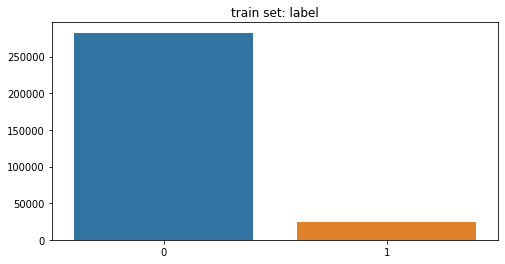

In [ ]:
plot_categorical(data=app_train, col='TARGET', size=[8 ,4], xlabel_angle=0, title='train set: label')

Occupation Type

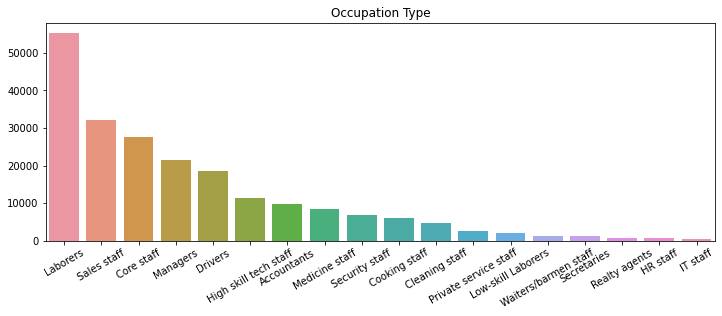

In [ ]:
plot_categorical(data=app_train, col='OCCUPATION_TYPE', size=[12 ,4], xlabel_angle=30, title='Occupation Type')

Gender

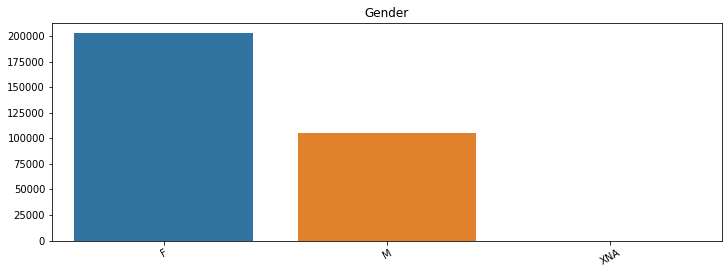

In [ ]:
plot_categorical(data=app_train, col='CODE_GENDER', size=[12 ,4], xlabel_angle=30, title='Gender')

Income Type

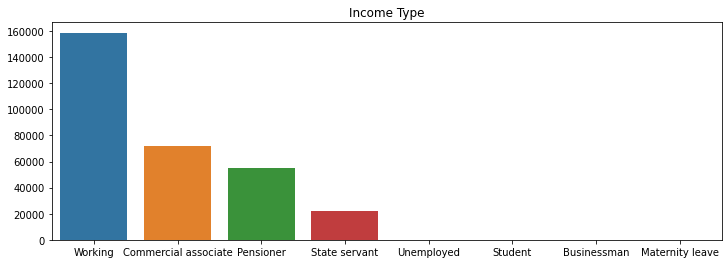

In [ ]:
plot_categorical(data=app_train, col='NAME_INCOME_TYPE', size=[12 ,4], xlabel_angle=0, title='Income Type')

House Type

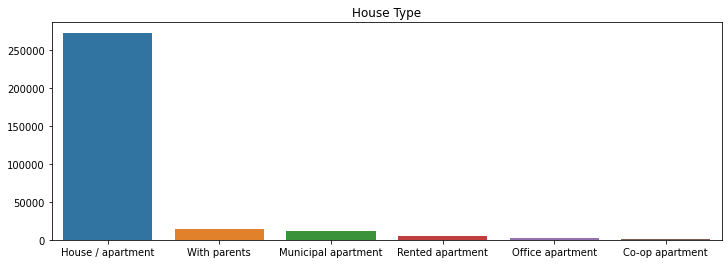

In [ ]:
plot_categorical(data=app_train, col='NAME_HOUSING_TYPE', size=[12 ,4], xlabel_angle=0, title='House Type')

Education

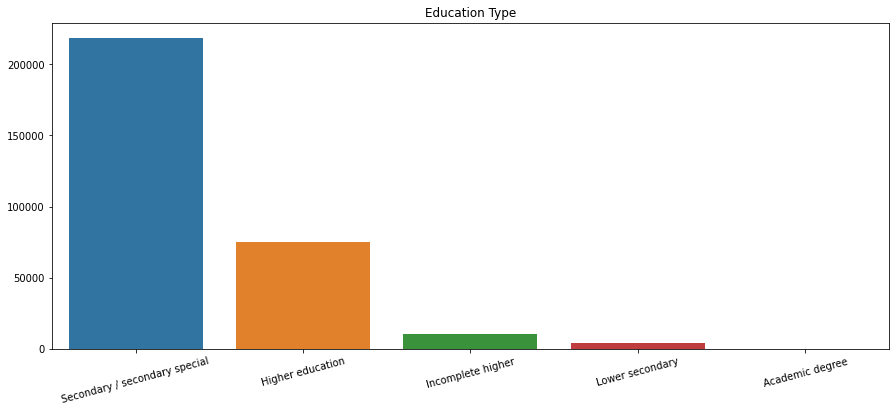

In [ ]:
plot_categorical(app_train, 'NAME_EDUCATION_TYPE', size=[15 ,6], xlabel_angle=15, title='Education Type')

**Numerical**

Credit Amount

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


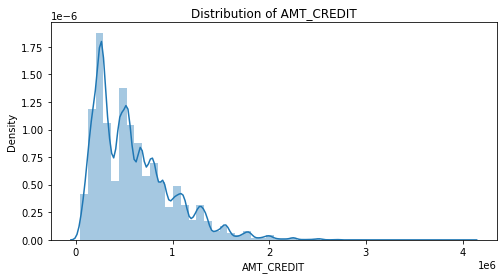

In [ ]:
plot_numerical(app_train, 'AMT_CREDIT')

Annuity Amount

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


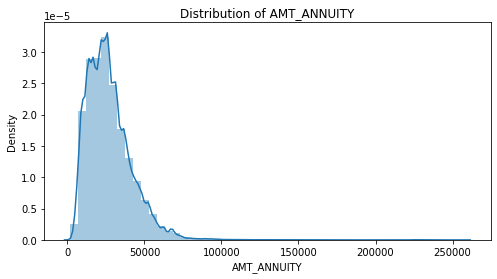

In [ ]:
plot_numerical(app_train, 'AMT_ANNUITY')

Days employed

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


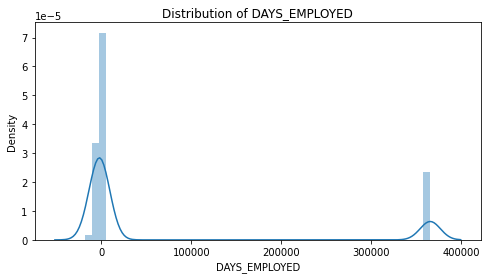

In [ ]:
plot_numerical(app_train, 'DAYS_EMPLOYED')

**Categorical and Numerical features by Label**

By Gender

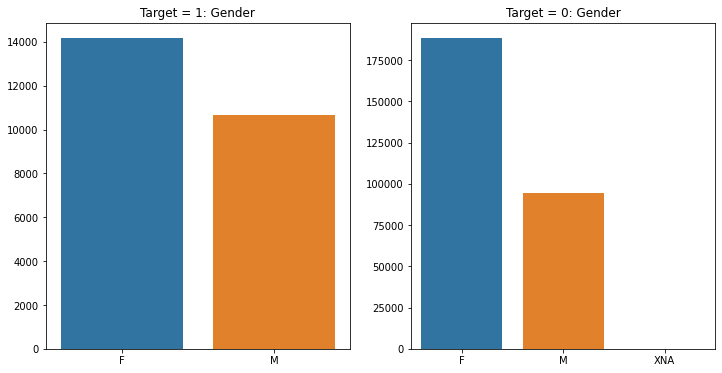

In [ ]:
plot_categorical_bylabel(app_train, 'CODE_GENDER', title='Gender')

By Education

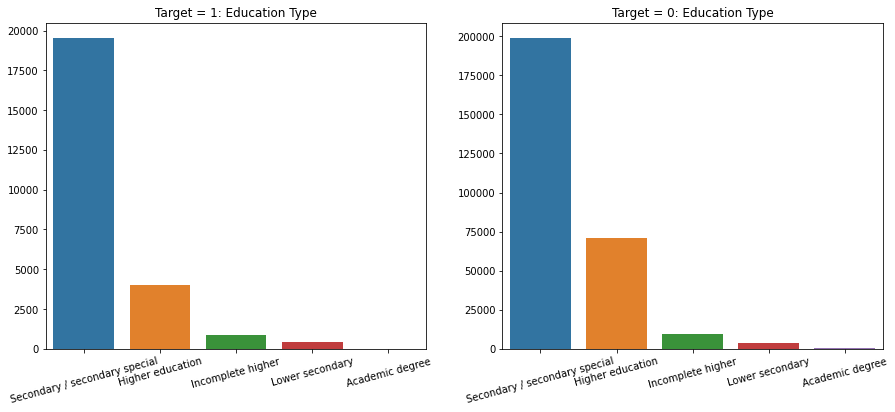

In [ ]:
plot_categorical_bylabel(app_train, 'NAME_EDUCATION_TYPE', size=[15 ,6], xlabel_angle=15, title='Education Type')

EXT_SOURCE 1

The correlation between EXT_SOURCE_1 and the TARGET is -0.1553


<Figure size 864x432 with 0 Axes>

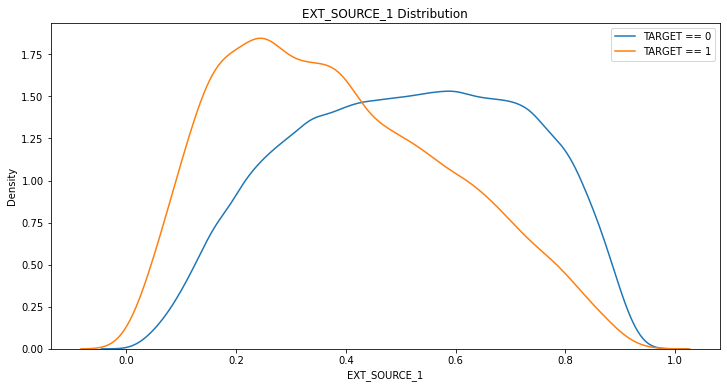

In [ ]:
plot_numerical_bylabel(app_train, 'EXT_SOURCE_1')

EXT_SOURCE 2

The correlation between EXT_SOURCE_2 and the TARGET is -0.1605


<Figure size 864x432 with 0 Axes>

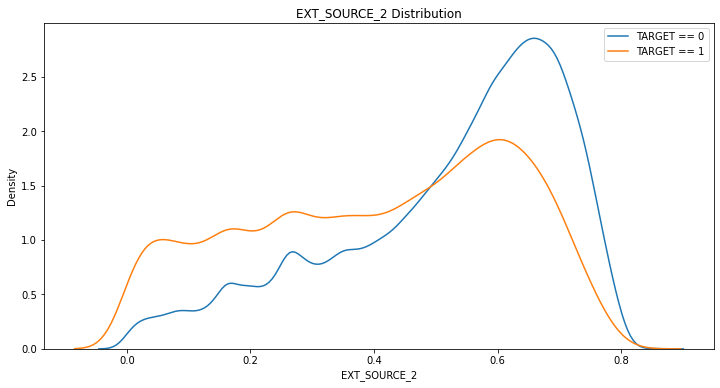

In [ ]:
plot_numerical_bylabel(app_train, 'EXT_SOURCE_2')

EXT_SOURCE 3

The correlation between EXT_SOURCE_3 and the TARGET is -0.1789


<Figure size 864x432 with 0 Axes>

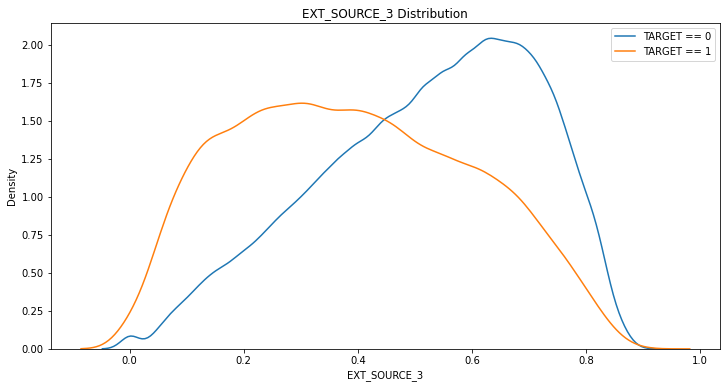

In [ ]:
plot_numerical_bylabel(app_train, 'EXT_SOURCE_3')

**Feature Engineering**

**Création des features (aggregation)**

Total crédit / annuity => Durée du prêt en années

In [ ]:
app_train["PERIOD"] = app_train.AMT_CREDIT / app_train.AMT_ANNUITY

Credit > Goods Price => False = 0 & True = 1

In [ ]:
app_train["OVER_EXPECT_CREDIT"] = (app_train.AMT_CREDIT > app_train.AMT_GOODS_PRICE).map({False:0, True:1})

Building AVG Score

['APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG',
       'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAREA_AVG']

In [ ]:
app_train['MEAN_BUILDING_SCORE_AVG'] = app_train.iloc[:, 44:58].mean(axis=1)
app_train['TOTAL_BUILDING_SCORE_AVG'] = app_train.iloc[:, 44:58].sum(axis=1)

FLAG_DOCUMENT_TOTAL: the total number of provided documents

['FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7',
       'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13',
       'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19',
       'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21']

In [ ]:
app_train['FLAG_DOCUMENT_TOTAL'] = app_train.iloc[:, 96:116].sum(axis=1)

AMT_REQ_CREDIT_BUREAU_TOTAL: the total number of enquiries (renseignements)

['AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [ ]:
app_train['AMT_REQ_CREDIT_BUREAU_TOTAL'] = app_train.iloc[:, 116:122].sum(axis=1)

BIRTH_EMPLOYED_INTERVEL: the days between born and employed

In [ ]:
app_train['BIRTH_EMPLOYED_INTERVEL'] = app_train.DAYS_EMPLOYED - app_train.DAYS_BIRTH

Income per family member

In [ ]:
app_train['INCOME_PER_FAMILY_MEMBER'] = app_train.AMT_INCOME_TOTAL / app_train.CNT_FAM_MEMBERS

Children Ratio

In [ ]:
app_train['CHILDREN_RATIO'] = app_train['CNT_CHILDREN'] / app_train['CNT_FAM_MEMBERS']

In [ ]:
app_train.shape

(307511, 185)

**Suppression des colonnes ayant servies à l'aggregation**

In [ ]:
app_train = app_train.drop(["AMT_GOODS_PRICE",'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG',
       'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG','FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG',
       'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG','NONLIVINGAREA_AVG','FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4',
       'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7','FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10',
       'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13','FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16',
       'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19','FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY','AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR',"DAYS_EMPLOYED","DAYS_BIRTH","AMT_INCOME_TOTAL","CNT_FAM_MEMBERS",
       "CNT_CHILDREN"],axis=1)

In [ ]:
app_train.shape

(307511, 139)

**Suppression des colonnes étant très peu remplies**

In [ ]:
(app_train.isnull().sum().sort_values(ascending=False)/app_train.shape[0]).head(20)

RATE_INTEREST_PRIVILEGED      0.985012
RATE_INTEREST_PRIMARY         0.985012
AMT_PAYMENT_CURRENT           0.801438
AMT_DRAWINGS_ATM_CURRENT      0.801178
AMT_DRAWINGS_OTHER_CURRENT    0.801178
AMT_DRAWINGS_POS_CURRENT      0.801178
CNT_DRAWINGS_ATM_CURRENT      0.801178
CNT_DRAWINGS_POS_CURRENT      0.801178
CNT_DRAWINGS_OTHER_CURRENT    0.801178
AMT_TOTAL_RECEIVABLE          0.717392
AMT_RECIVABLE                 0.717392
SK_DPD_DEF                    0.717392
AMT_PAYMENT_TOTAL_CURRENT     0.717392
SK_DPD                        0.717392
AMT_INST_MIN_REGULARITY       0.717392
CNT_INSTALMENT_MATURE_CUM     0.717392
AMT_DRAWINGS_CURRENT          0.717392
AMT_CREDIT_LIMIT_ACTUAL       0.717392
AMT_RECEIVABLE_PRINCIPAL      0.717392
MONTHS_BALANCE                0.717392
dtype: float64

In [ ]:
app_train = app_train.drop(["RATE_INTEREST_PRIMARY","RATE_INTEREST_PRIVILEGED","AMT_PAYMENT_CURRENT","CNT_DRAWINGS_ATM_CURRENT","AMT_DRAWINGS_ATM_CURRENT",
                "AMT_DRAWINGS_OTHER_CURRENT","AMT_DRAWINGS_POS_CURRENT","CNT_DRAWINGS_POS_CURRENT","CNT_DRAWINGS_OTHER_CURRENT", "CNT_DRAWINGS_ATM_CURRENT"],axis=1)

In [ ]:
app_train.shape

(307511, 130)

**Suppression des colonnes numériques étant fortement corrélés entre elles (>0.8) en excluant la TARGET cf => Doublons**

In [ ]:
data_no_target = app_train.drop(["TARGET"],axis=1)

In [ ]:
features_corr = correlation(data_no_target, 0.8)

In [ ]:
print("Nombre de colonnes :",len(features_corr),"\n",features_corr)

Nombre de colonnes : 35 
 {'OBS_60_CNT_SOCIAL_CIRCLE', 'LIVE_CITY_NOT_WORK_CITY', 'NONLIVINGAPARTMENTS_MEDI', 'ELEVATORS_MODE', 'AMT_TOTAL_RECEIVABLE', 'NUM_INSTALMENT_NUMBER', 'NONLIVINGAREA_MEDI', 'MEAN_BUILDING_SCORE_AVG', 'TOTALAREA_MODE', 'AMT_INST_MIN_REGULARITY', 'FLOORSMAX_MEDI', 'LIVINGAPARTMENTS_MEDI', 'DAYS_ENTRY_PAYMENT', 'DAYS_DECISION', 'APARTMENTS_MEDI', 'FLOORSMIN_MEDI', 'ENTRANCES_MEDI', 'YEARS_BUILD_MEDI', 'AMT_RECIVABLE', 'AMT_RECEIVABLE_PRINCIPAL', 'LIVINGAREA_MODE', 'AMT_PAYMENT_TOTAL_CURRENT', 'BASEMENTAREA_MEDI', 'LANDAREA_MEDI', 'CNT_INSTALMENT_FUTURE', 'TOTAL_BUILDING_SCORE_AVG', 'COMMONAREA_MEDI', 'REGION_RATING_CLIENT_W_CITY', 'LIVE_REGION_NOT_WORK_REGION', 'DAYS_TERMINATION', 'YEARS_BEGINEXPLUATATION_MEDI', 'DEF_60_CNT_SOCIAL_CIRCLE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MEDI', 'ELEVATORS_MEDI'}


In [ ]:
app_train = app_train.drop(features_corr,axis=1)

In [ ]:
app_train.shape

(307511, 95)

**Analyse des NaN**

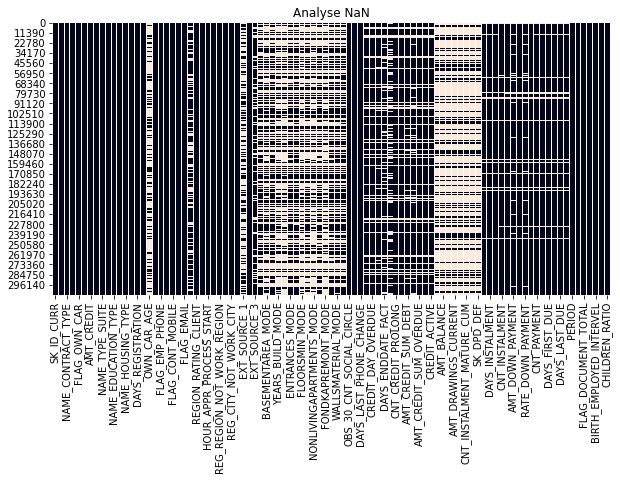

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Analyse NaN")
sns.heatmap(app_train.isna(), cbar=False)

**Split Cat, Num**

In [ ]:
cat_list, num_list = feature_type_split(app_train)

print(str(len(cat_list)),'categorical features:', cat_list)
print('-----------------------------------------')
print(str(len(num_list)),'continuous numerical features:',num_list)

17 categorical features: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE', 'CREDIT_ACTIVE']
-----------------------------------------
78 continuous numerical features: ['SK_ID_CURR', 'TARGET', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'REGION_RATING_CLIENT', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONA

**Remplissage des données numériques via Iterative Imputer**

In [ ]:
app_train[num_list] = IterativeImputer().fit_transform(app_train[num_list])

/usr/local/lib/python3.7/dist-packages/sklearn/impute/_iterative.py:638: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


**Remplissage des données catégoriques via SimpleImputer**

In [ ]:
app_train[cat_list] = SimpleImputer(strategy='most_frequent').fit_transform(app_train[cat_list])

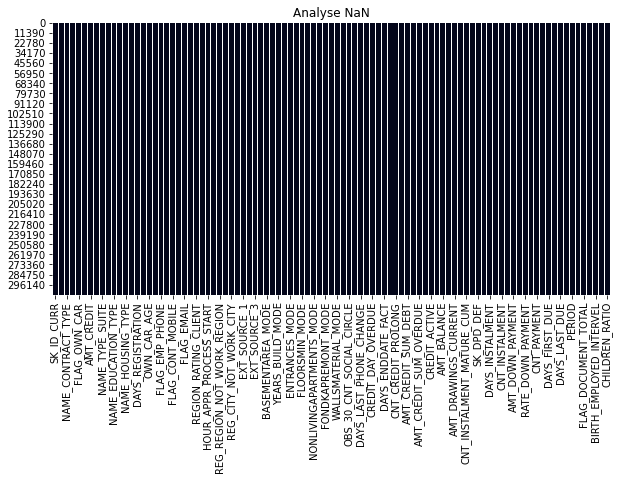

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Analyse NaN")
sns.heatmap(app_train.isna(), cbar=False)

**Labélisation des colonnes catégoriques**

In [ ]:
app_train[cat_list]

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,CREDIT_ACTIVE
0,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,"Stone, brick",No,Closed
1,Cash loans,F,N,N,Family,State servant,Higher education,Married,House / apartment,Core staff,MONDAY,School,reg oper account,block of flats,Block,No,Closed
2,Revolving loans,M,Y,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Laborers,MONDAY,Government,reg oper account,block of flats,Panel,No,Closed
3,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,Laborers,WEDNESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No,Closed
4,Cash loans,M,N,Y,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,Core staff,THURSDAY,Religion,reg oper account,block of flats,Panel,No,Closed
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,Cash loans,M,N,N,Unaccompanied,Working,Secondary / secondary special,Separated,With parents,Sales staff,THURSDAY,Services,reg oper account,block of flats,"Stone, brick",No,Closed
307507,Cash loans,F,N,Y,Unaccompanied,Pensioner,Secondary / secondary special,Widow,House / apartment,Laborers,MONDAY,XNA,reg oper account,block of flats,"Stone, brick",No,Closed
307508,Cash loans,F,N,Y,Unaccompanied,Working,Higher education,Separated,House / apartment,Managers,THURSDAY,School,reg oper account,block of flats,Panel,No,Closed
307509,Cash loans,F,N,Y,Unaccompanied,Commercial associate,Secondary / secondary special,Married,House / apartment,Laborers,WEDNESDAY,Business Entity Type 1,reg oper account,block of flats,"Stone, brick",No,Closed


In [ ]:
labelencoder = LabelEncoder()

for col in app_train[cat_list]:
    app_train[col] = labelencoder.fit_transform(app_train[col])

In [ ]:
app_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_ANNUITY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,REGION_RATING_CLIENT,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,...,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,CREDIT_ACTIVE,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,CNT_DRAWINGS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF,NUM_INSTALMENT_VERSION,DAYS_INSTALMENT,AMT_PAYMENT,CNT_INSTALMENT,AMT_APPLICATION,AMT_DOWN_PAYMENT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,NFLAG_INSURED_ON_APPROVAL,PERIOD,OVER_EXPECT_CREDIT,FLAG_DOCUMENT_TOTAL,AMT_REQ_CREDIT_BUREAU_TOTAL,BIRTH_EMPLOYED_INTERVEL,INCOME_PER_FAMILY_MEMBER,CHILDREN_RATIO
0,100002.0,1.0,0,1,0,1,406597.5,24700.5,6,7,4,3,1,0.018801,-3648.0,-2120.0,20.423145,1.0,1.0,0.0,1.0,1.0,0.0,8,2.0,6,10.0,0.0,0.0,0.0,0.0,5,0.083037,0.262949,0.139376,0.025200,0.038300,0.972200,0.634100,0.014400,...,-349.000000,-697.500000,1681.029000,0.000000,108131.945625,49156.200000,7997.141250,0.000000,-499.875000,2,-9.774510,131079.249750,179887.555152,16470.516557,3.016699,1.990798,-7.322679,1.908601,1.052632,-295.000000,11559.247105,24.000000,179055.000,0.00,1.0,0.000000,500.000000,24.000000,365243.0,-565.000000,125.000000,-25.000000,0.000000,16.461104,1.0,1.0,1.0,8824.0,202500.0,0.0
1,100003.0,0.0,0,0,0,0,1293502.5,35698.5,1,4,1,1,1,0.003541,-1186.0,-291.0,15.263779,1.0,1.0,0.0,1.0,1.0,0.0,3,1.0,1,11.0,0.0,0.0,0.0,0.0,39,0.311267,0.622246,0.533242,0.092400,0.053800,0.985100,0.804000,0.049700,...,-544.500000,-1097.333333,0.000000,0.000000,254350.125000,0.000000,202500.000000,0.000000,-816.000000,2,-24.999958,97454.912934,274194.442897,37641.500718,3.408183,9.521108,27.448312,1.454572,1.040000,-1378.160000,64754.586000,10.107143,435436.500,3442.50,1.0,0.050030,533.000000,10.000000,365243.0,-1274.333333,-1004.333333,-1054.333333,0.666667,36.234085,1.0,1.0,0.0,15577.0,135000.0,0.0
2,100004.0,0.0,1,1,1,1,135000.0,6750.0,6,7,4,3,1,0.010032,-4260.0,-2531.0,26.000000,1.0,1.0,1.0,1.0,1.0,0.0,8,2.0,1,9.0,0.0,0.0,0.0,0.0,11,0.549739,0.555912,0.729567,0.100915,0.080185,0.984264,0.775606,0.035539,...,-488.500000,-532.500000,0.000000,0.000000,94518.900000,0.000000,0.000000,0.000000,-532.000000,2,-13.045689,34694.255579,201417.655668,11129.501304,1.806802,3.336162,-0.784368,-4.999101,1.333333,-754.000000,7096.155000,3.750000,24282.000,4860.00,1.0,0.212008,30.000000,4.000000,365243.0,-784.000000,-694.000000,-724.000000,0.000000,20.000000,0.0,0.0,0.0,18821.0,67500.0,0.0
3,100006.0,0.0,0,0,0,1,312682.5,29686.5,6,7,4,0,1,0.008019,-9833.0,-2437.0,13.164939,1.0,1.0,0.0,1.0,0.0,0.0,8,2.0,6,17.0,0.0,0.0,0.0,0.0,5,0.580276,0.650442,0.535752,0.105439,0.076287,0.976547,0.744861,0.031801,...,578.316347,-835.243108,-212660.882083,0.008977,292856.565848,145817.968598,4505.156196,-211.824328,-519.143176,2,-3.500000,0.000000,270000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.125000,-252.250000,62947.088438,12.000000,272203.260,34840.17,1.0,0.163412,894.222222,23.000000,365243.0,91066.500000,91584.000000,182477.500000,0.000000,10.532818,1.0,1.0,0.0,15966.0,67500.0,0.0
4,100007.0,0.0,0,1,0,1,513000.0,21865.5,6,7,4,3,1,0.028663,-4311.0,-3458.0,12.614294,1.0,1.0,0.0,1.0,0.0,0.0,3,2.0,4,11.0,0.0,0.0,0.0,1.0,37,0.509906,0.322738,0.550610,0.09469

In [ ]:
app_train.to_csv("/content/gdrive/MyDrive/Colab Notebooks/Projet_7/df_final.csv")